# **14 - Analytical Fragility Function Processing and Application**

**IRDR0012 MSc Independent Research Project**

*   Candidate number: NWHL6
*   Institution: UCL IRDR
*   Supervisor: Dr. Roberto Gentile
*   Date: 01/09/2025
*   Version: v1.0

**Description:**

This script retrieves selected analytical fragility functions from the GEM Global
Vulnerability Database and applies them to the Morocco earthquake exposure model
to predict damage states for comparison with empirical observations.

**INPUT FILES:**

*   NWHL6-CSV-P01_Villa-Vega_2017_Fragility function_masonry.csv

**OUTPUT FILES:**

*   analytical_predictions_AkkarEtAlRjb2014.csv
*   analytical_predictions_ChiouYoungs2014.csv
*   analytical_predictions_summary.csv

# 0. ENVIRONMENT SETUP

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
from urllib.parse import urljoin
import json
import math
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("=" * 70)
print("SCRIPT 1: ANALYTICAL FRAGILITY FUNCTION PROCESSING")
print("=" * 70)
print("Environment setup complete")
print("Libraries imported successfully")

SCRIPT 1: ANALYTICAL FRAGILITY FUNCTION PROCESSING
Environment setup complete
Libraries imported successfully


# 1. DATA PATHS AND CONFIGURATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
INPUT_FOLDER = '/content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/'
OUTPUT_FOLDER = '/content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/'

print(f"Google Drive mounted successfully")
print(f"Input folder: {INPUT_FOLDER}")
print(f"Output folder: {OUTPUT_FOLDER}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully
Input folder: /content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/
Output folder: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/


# 2. FRAGILITY FUNCTION SELECTION CONFIGURATION

FRAGILITY FUNCTION SELECTION RATIONALE:

Based on exposure data analysis, the following building classes have sufficient
sample sizes for meaningful statistical analysis:

- MCF/LFINF H:2 (117 buildings) -> Villar-Vega MCF/LWAL+DNO/H:2 (ID 562)
- MCF/LFINF H:3 (131 buildings) -> Villar-Vega MCF/LWAL+DNO/H:3 (ID 564)
- EU/LWAL H:1 (41 buildings)    -> Villar-Vega MUR+ADO/LWAL+DNO/H:1 (ID 565)

ASSUMPTIONS:
- MCF/LFINF buildings approximated as MCF/LWAL (infilled frame ≈ wall system)
- EU earth buildings treated as adobe construction (MUR+ADO)
- DNO (non-ductile) design level assumed for all buildings

In [ ]:
# Selected fragility functions configuration
SELECTED_FUNCTIONS = {
    'MCF_H2': {
        'id': 562,
        'gem_filename': '562__Villar-Vega (2014) - MCF_,_H_2_,_DNO.nrml',
        'description': 'MCF/LWAL+DNO/HEX:2/RES',
        'imt': 'SA(0.3)',
        'exposure_match': 'MCF/LFINF/H:2'
    },
    'MCF_H3': {
        'id': 564,
        'gem_filename': '564__Villar-Vega (2014) - MCF_,_H_3_,_DNO.nrml',
        'description': 'MCF/LWAL+DNO/HEX:3/RES',
        'imt': 'SA(1.0)',
        'exposure_match': 'MCF/LFINF/H:3'
    },
    'EU_H1': {
        'id': 565,
        'gem_filename': '565__Villar-Vega (2014) - MUR+ADO_,_H_1.nrml',
        'description': 'MUR+ADO/LWAL+DNO/HEX:1/RES',
        'imt': 'PGA',
        'exposure_match': 'EU/LWAL/H:1'
    }
}

# GMPE models to process
GMPE_MODELS = ['AkkarEtAlRjb2014', 'ChiouYoungs2014']

print("\nFragility Function Selection:")
print("-" * 50)
for key, func in SELECTED_FUNCTIONS.items():
    print(f"{key}: {func['description']} (IMT: {func['imt']})")

print(f"\nGMPE Models: {GMPE_MODELS}")


Fragility Function Selection:
--------------------------------------------------
MCF_H2: MCF/LWAL+DNO/HEX:2/RES (IMT: SA(0.3))
MCF_H3: MCF/LWAL+DNO/HEX:3/RES (IMT: SA(1.0))
EU_H1: MUR+ADO/LWAL+DNO/HEX:1/RES (IMT: PGA)

GMPE Models: ['AkkarEtAlRjb2014', 'ChiouYoungs2014']


# 3. GEM FRAGILITY FUNCTION RETRIEVAL

FRAGILITY FUNCTION DOWNLOAD

Load fragility function parameters from the original Villar-Vega (2017) paper
data instead of downloading from GEM repository. This ensures we use the exact
parameters as published in the research paper.

In [ ]:
def load_villar_vega_parameters():
    """
    Load Villar-Vega fragility function parameters from CSV file.

    Returns:
    --------
    dict : Fragility function parameters organized by building class
    """
    filename = f'{INPUT_FOLDER}NWHL6-CSV-P01_Villa-Vega_2017_Fragility function_masonry.csv'

    try:
        df = pd.read_csv(filename)
        print(f"✓ Loaded Villar-Vega parameters from original paper")
        print(f"Available typologies: {list(df['Typology'].unique())}")

        # Map typologies to our building classes
        typology_mapping = {
            'MCF_H2': 'MCF/H:2/DNO',
            'MCF_H3': 'MCF/H:3/DNO',
            'EU_H1': 'MUR+ADO/H:1'
        }

        fragility_functions = {}

        for class_key, typology in typology_mapping.items():
            # Find matching row in CSV
            matching_rows = df[df['Typology'] == typology]

            if len(matching_rows) == 0:
                print(f"Warning: No parameters found for {typology}")
                continue

            row = matching_rows.iloc[0]

            # Extract parameters
            imt = row['IM']

            # Create parameter structure
            fragility_functions[class_key] = {
                'config': SELECTED_FUNCTIONS[class_key],
                'parameters': {
                    'imt_info': {
                        'IMT': imt,
                        'unit': 'g',
                        'min_IML': 0.0,
                        'max_IML': 2.5
                    },
                    'damage_states': {
                        'slight': {
                            'mean_ln': row['Slight_λ'],
                            'stddev': row['Slight_x']
                        },
                        'moderate': {
                            'mean_ln': row['Moderate_λ'],
                            'stddev': row['Moderate_x']
                        },
                        'extensive': {
                            'mean_ln': row['Extensive_λ'],
                            'stddev': row['Extensive_x']
                        },
                        'complete': {
                            'mean_ln': row['Collapse_λ'],
                            'stddev': row['Collapse_x']
                        }
                    }
                }
            }

            print(f"✓ Loaded parameters for {class_key} ({typology}, IMT: {imt})")

        return fragility_functions

    except FileNotFoundError:
        print(f"✗ File not found: {filename}")
        return {}
    except Exception as e:
        print(f"✗ Error loading parameters: {e}")
        return {}

print("\n" + "=" * 70)
print("LOADING VILLAR-VEGA FRAGILITY FUNCTION PARAMETERS")
print("=" * 70)

# Load fragility function parameters from original paper
fragility_functions = load_villar_vega_parameters()

if len(fragility_functions) == 0:
    print("✗ No fragility functions loaded. Check input file and parameters.")
    exit()

print(f"\n✓ Successfully loaded {len(fragility_functions)} fragility functions from Villar-Vega (2017)")



LOADING VILLAR-VEGA FRAGILITY FUNCTION PARAMETERS
✓ Loaded Villar-Vega parameters from original paper
Available typologies: ['MUR/H:1', 'MUR/H:2', 'MUR/H:3', 'MUR+ADO/H:1', 'MUR+ADO/H:2', 'MUR+ST99/H:1', 'MUR+ST99/H:2', 'MCF/H:1', 'MCF/H:2', 'MCF/H:3', 'MCF/H:1/DNO', 'MCF/H:2/DNO', 'MCF/H:3/DNO']
✓ Loaded parameters for MCF_H2 (MCF/H:2/DNO, IMT: Sa(0.3))
✓ Loaded parameters for MCF_H3 (MCF/H:3/DNO, IMT: Sa(1.0))
✓ Loaded parameters for EU_H1 (MUR+ADO/H:1, IMT: PGA)

✓ Successfully loaded 3 fragility functions from Villar-Vega (2017)


# 4. FRAGILITY FUNCTION VISUALISATION

Visualize the downloaded analytical fragility functions to understand their
characteristics and damage state thresholds before applying to building data.


VISUALIZING ANALYTICAL FRAGILITY FUNCTIONS

DETAILED FRAGILITY FUNCTION PARAMETERS

MCF_H2 - MCF/LWAL+DNO/HEX:2/RES
----------------------------------------------------------------------
Fragility ID: 562
IMT: Sa(0.3) (g)
IMT Range: 0.00 - 2.5 g

Damage State Parameters (Lognormal Distribution):
State        Mean(ln)   Std Dev    Median(g)   
--------------------------------------------------
Slight       -0.7000    0.3710     0.4966      
Moderate     0.1300     0.3510     1.1388      
Extensive    0.3810     0.4330     1.4637      
Complete     0.8080     0.4900     2.2434      

MCF_H3 - MCF/LWAL+DNO/HEX:3/RES
----------------------------------------------------------------------
Fragility ID: 564
IMT: Sa(1.0) (g)
IMT Range: 0.00 - 2.5 g

Damage State Parameters (Lognormal Distribution):
State        Mean(ln)   Std Dev    Median(g)   
--------------------------------------------------
Slight       -2.4220    0.4950     0.0887      
Moderate     -1.5920    0.5730     0.2035      
Ex

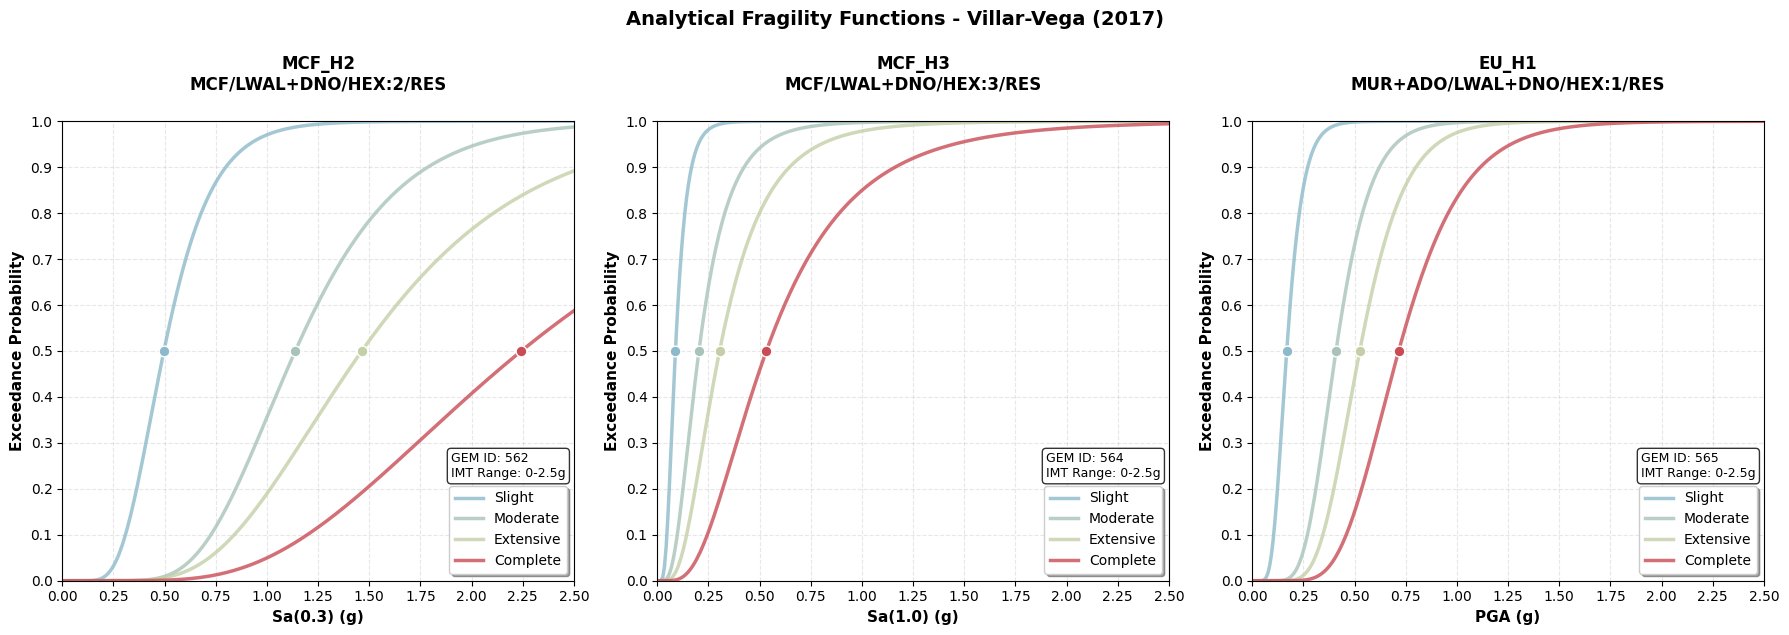


✓ Fragility function visualization completed
✓ 3 functions visualized

Fragility Function Summary:
--------------------------------------------------
MCF_H2: Complete damage at 2.243g Sa(0.3)
MCF_H3: Complete damage at 0.533g Sa(1.0)
EU_H1: Complete damage at 0.715g PGA


In [ ]:
def plot_fragility_functions(fragility_functions):
    """
    Plot all downloaded fragility functions for visual inspection.

    Parameters:
    -----------
    fragility_functions : dict
        Dictionary of fragility function parameters
    """

    # Set up the plotting
    n_functions = len(fragility_functions)
    fig, axes = plt.subplots(1, n_functions, figsize=(6*n_functions, 6))
    if n_functions == 1:
        axes = [axes]

    # Color scheme for damage states
    colors = {
        'slight': '#8DB9CA',     # Light blue
        'moderate': '#A8C4B8',   # Blue-green
        'extensive': '#C3CFA6',  # Green-yellow
        'complete': '#C94B54'    # Red
    }

    for idx, (function_key, func_data) in enumerate(fragility_functions.items()):
        ax = axes[idx]

        # Get function parameters
        config = func_data['config']
        params = func_data['parameters']

        # Get IMT info
        imt_info = params['imt_info']
        imt_name = imt_info['IMT']
        imt_unit = imt_info['unit']
        max_imt = min(imt_info.get('max_IML', 2.5), 2.5)  # Cap at 2.0g for readability

        # Create IMT range
        imt_range = np.linspace(0.01, max_imt, 300)

        print(f"\nPlotting {function_key}:")
        print(f"  Description: {config['description']}")
        print(f"  IMT: {imt_name} ({imt_unit})")

        # Plot each damage state
        for damage_state, state_params in params['damage_states'].items():
            mean_ln = state_params['mean_ln']
            stddev = state_params['stddev']

            # Calculate fragility curve: P(DS >= state | IMT)
            probabilities = norm.cdf((np.log(imt_range) - mean_ln) / stddev)

            # Plot curve
            ax.plot(imt_range, probabilities,
                   color=colors.get(damage_state.lower(), 'gray'),
                   linewidth=2.5,
                   label=f'{damage_state.capitalize()}',
                   alpha=0.8)

            # Add median point (where P = 0.5)
            median_imt = math.exp(mean_ln)
            if median_imt <= max_imt:
                ax.scatter([median_imt], [0.5],
                          color=colors.get(damage_state.lower(), 'gray'),
                          s=60, zorder=5,
                          edgecolor='white', linewidth=1)

        # Customize subplot
        ax.set_xlabel(f'{imt_name} ({imt_unit})', fontsize=11, fontweight='bold')
        ax.set_ylabel('Exceedance Probability', fontsize=11, fontweight='bold')
        ax.set_title(f'{function_key}\n{config["description"]}',
                    fontsize=12, fontweight='bold', y=1.05)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xlim(0, max_imt)
        ax.set_ylim(0, 1)
        ax.set_xticks(np.arange(0, max_imt+0.1, 0.25))
        ax.set_yticks(np.arange(0, 1.1, 0.10))
        ax.legend(loc='lower right', frameon=True, fancybox=True,
                 shadow=True, fontsize=10)

        # Add parameter info box
        param_info = f"GEM ID: {config['id']}\nIMT Range: 0-{max_imt}{imt_unit}"
        ax.text(0.76, 0.28, param_info, transform=ax.transAxes,
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.suptitle('Analytical Fragility Functions - Villar-Vega (2017)',
                 fontsize=14, fontweight='bold', y=1.05)
    plt.show()

    return fig

def display_fragility_parameters(fragility_functions):
    """
    Display detailed parameters for all fragility functions in tabular format.

    Parameters:
    -----------
    fragility_functions : dict
        Dictionary of fragility function parameters
    """

    print(f"\n" + "=" * 80)
    print("DETAILED FRAGILITY FUNCTION PARAMETERS")
    print("=" * 80)

    for function_key, func_data in fragility_functions.items():
        config = func_data['config']
        params = func_data['parameters']
        imt_info = params['imt_info']

        print(f"\n{function_key.upper()} - {config['description']}")
        print("-" * 70)
        print(f"Fragility ID: {config['id']}")
        print(f"IMT: {imt_info['IMT']} ({imt_info['unit']})")
        print(f"IMT Range: {imt_info.get('min_IML', 0):.2f} - {imt_info.get('max_IML', 'N/A')} {imt_info['unit']}")

        print(f"\nDamage State Parameters (Lognormal Distribution):")
        print(f"{'State':<12} {'Mean(ln)':<10} {'Std Dev':<10} {'Median(g)':<12}")
        print("-" * 50)

        for state, state_params in params['damage_states'].items():
            mean_ln = state_params['mean_ln']
            stddev = state_params['stddev']
            median_g = math.exp(mean_ln)

            print(f"{state.capitalize():<12} {mean_ln:<10.4f} {stddev:<10.4f} {median_g:<12.4f}")

print("\n" + "=" * 70)
print("VISUALIZING ANALYTICAL FRAGILITY FUNCTIONS")
print("=" * 70)

if len(fragility_functions) > 0:
    # Display detailed parameters
    display_fragility_parameters(fragility_functions)

    # Create visualization
    print(f"\nGenerating fragility function plots...")
    fragility_plot = plot_fragility_functions(fragility_functions)

    print(f"\n✓ Fragility function visualization completed")
    print(f"✓ {len(fragility_functions)} functions visualized")

    # Summary of function characteristics
    print(f"\nFragility Function Summary:")
    print("-" * 50)
    for key, func_data in fragility_functions.items():
        config = func_data['config']
        params = func_data['parameters']

        # Find the complete damage state median
        if 'complete' in params['damage_states']:
            complete_median = math.exp(params['damage_states']['complete']['mean_ln'])
            print(f"{key}: Complete damage at {complete_median:.3f}g {params['imt_info']['IMT']}")

else:
    print("No fragility functions available for visualization")

# 5. EXPOSURE MODEL LOADING AND PROCESSING

Load the pre-filtered exposure model containing buildings already classified
by building type. This dataset contains only buildings that match our target
fragility function categories.

In [ ]:
def load_filtered_exposure_data():
    """
    Load pre-filtered exposure model data.

    Returns:
    --------
    DataFrame : Pre-filtered exposure model data
    """
    filename = f'{INPUT_FOLDER}NWHL6-CSV-P01_Exposure model_Master_filtered for analysis.csv'

    try:
        df = pd.read_csv(filename)
        print(f"  ✓ Loaded {len(df):,} pre-filtered records")
        print(f"  DEBUG: Columns available: {list(df.columns)}")

        # Show building class distribution
        if 'building_class' in df.columns:
            class_dist = df['building_class'].value_counts()
            print(f"  DEBUG: Building class distribution:")
            for building_class, count in class_dist.items():
                print(f"    {building_class}: {count}")

        return df
    except FileNotFoundError:
        print(f"  ✗ File not found: {filename}")
        return None

print("\n" + "=" * 70)
print("LOADING PRE-FILTERED EXPOSURE MODEL")
print("=" * 70)

# Load the pre-filtered exposure data
filtered_exposure_df = load_filtered_exposure_data()

if filtered_exposure_df is None or filtered_exposure_df.empty:
    print("✗ Could not load filtered exposure data. Exiting.")
    exit()

print(f"✓ Loaded {len(filtered_exposure_df):,} buildings ready for fragility analysis")



LOADING PRE-FILTERED EXPOSURE MODEL
  ✓ Loaded 2,508 pre-filtered records
  DEBUG: Columns available: ['ID', 'Location', 'Region', 'Latitute', 'Longitude', 'DG', 'Material LLRS', 'LLRS', 'Height', 'Date of construction', 'Occupancy', 'Structural Irregularity', 'Roof', 'parsed_material', 'parsed_height', 'parsed_occupancy', 'building_class']
  DEBUG: Building class distribution:
    EU_H1: 1346
    MCF_H2: 1011
    MCF_H3: 151
✓ Loaded 2,508 buildings ready for fragility analysis


# 6. FRAGILITY FUNCTION APPLICATION

Load ground motion data from GMPE files and apply fragility functions to predict
damage states. The process involves:
1. Loading GMPE ground motion predictions
2. Merging with analytical framework based on building IDs
3. Applying lognormal fragility functions
4. Calculating damage state probabilities and most probable states

Apply lognormal fragility functions to predict damage state probabilities for
each building. The fragility functions define P(DS ≥ damage_state | IMT) where
damage states are: Slight, Moderate, Extensive, Complete.

Mathematical formulation:
P(DS ≥ ds | IMT) = Φ((ln(IMT) - μ) / σ)

where Φ is the standard normal CDF, μ is mean_ln, and σ is stddev.

In [ ]:
def load_gmpe_data(gmpe_model):
    """
    Load GMPE ground motion data.

    Parameters:
    -----------
    gmpe_model : str
        GMPE model name

    Returns:
    --------
    DataFrame : GMPE data with ground motion predictions
    """
    filename = f'{INPUT_FOLDER}exposure_gmpe_{gmpe_model}.csv'

    try:
        df = pd.read_csv(filename)
        print(f"  ✓ Loaded {len(df):,} GMPE records for {gmpe_model}")
        return df
    except FileNotFoundError:
        print(f"  ✗ File not found: {filename}")
        return None

def merge_framework_with_gmpe(framework_df, gmpe_df, gmpe_model):
    """
    Merge analytical framework with GMPE ground motion data.

    Parameters:
    -----------
    framework_df : DataFrame
        Analytical framework with building classifications
    gmpe_df : DataFrame
        GMPE ground motion predictions
    gmpe_model : str
        GMPE model name

    Returns:
    --------
    DataFrame : Merged data ready for fragility analysis
    """
    print(f"  Merging framework with {gmpe_model} data...")

    # Create mapping for each building class to required IMT
    merged_records = []

    for _, building in framework_df.iterrows():
        building_id = building['id']
        required_imt = building['required_imt']

        # Find matching GMPE record with required IMT
        gmpe_matches = gmpe_df[
            (gmpe_df['id'] == building_id) &
            (gmpe_df['imt'] == required_imt)
        ]

        if len(gmpe_matches) > 0:
            gmpe_record = gmpe_matches.iloc[0]

            # Combine framework and GMPE data
            merged_record = building.copy()
            merged_record['gmpe_model'] = gmpe_model
            merged_record['imt_mean'] = gmpe_record['mean']
            merged_record['imt_std'] = gmpe_record['std']
            merged_record['imt_p5'] = gmpe_record['p5']
            merged_record['imt_p16'] = gmpe_record['p16']
            merged_record['imt_p50'] = gmpe_record['p50']
            merged_record['imt_p84'] = gmpe_record['p84']
            merged_record['imt_p95'] = gmpe_record['p95']

            merged_records.append(merged_record)

    merged_df = pd.DataFrame(merged_records)
    print(f"  ✓ Successfully merged {len(merged_df):,} buildings")

    return merged_df

def calculate_damage_probabilities(imt_value, fragility_params):
    """
    Calculate damage state exceedance probabilities using lognormal fragility function.

    Parameters:
    -----------
    imt_value : float
        Ground motion intensity value
    fragility_params : dict
        Fragility function parameters

    Returns:
    --------
    dict : Exceedance probabilities for each damage state
    """
    if pd.isna(imt_value) or imt_value <= 0:
        return {ds: 0.0 for ds in ['slight', 'moderate', 'extensive', 'complete']}

    probabilities = {}
    damage_states = fragility_params['damage_states']

    for damage_state, params in damage_states.items():
        mean_ln = params['mean_ln']
        stddev = params['stddev']

        # Calculate P(DS ≥ damage_state | IMT) using lognormal CDF
        prob = norm.cdf((math.log(imt_value) - mean_ln) / stddev)
        probabilities[damage_state.lower()] = prob

    return probabilities

def determine_most_probable_damage_state(exceedance_probs):
    """
    Determine most probable damage state from exceedance probabilities.

    Parameters:
    -----------
    exceedance_probs : dict
        Exceedance probabilities

    Returns:
    --------
    str : Most probable damage state
    """
    # Convert exceedance to differential probabilities
    p_none = 1.0 - exceedance_probs.get('slight', 0)
    p_slight = exceedance_probs.get('slight', 0) - exceedance_probs.get('moderate', 0)
    p_moderate = exceedance_probs.get('moderate', 0) - exceedance_probs.get('extensive', 0)
    p_extensive = exceedance_probs.get('extensive', 0) - exceedance_probs.get('complete', 0)
    p_complete = exceedance_probs.get('complete', 0)

    # Find maximum probability
    probs = {
        'None': p_none,
        'Slight': p_slight,
        'Moderate': p_moderate,
        'Extensive': p_extensive,
        'Complete': p_complete
    }

    return max(probs, key=probs.get)

def apply_fragility_functions(merged_df, fragility_functions):
    """
    Apply fragility functions to predict damage states for all percentiles.

    Parameters:
    -----------
    merged_df : DataFrame
        Merged framework and GMPE data
    fragility_functions : dict
        Fragility function parameters

    Returns:
    --------
    DataFrame : Data with damage state predictions
    """
    results = []

    print(f"  Applying fragility functions to {len(merged_df):,} buildings...")

    for _, building in merged_df.iterrows():
        building_class = building['building_class']

        if building_class not in fragility_functions:
            continue

        # Get fragility parameters
        fragility_params = fragility_functions[building_class]['parameters']

        # Create result record starting with all building data
        result = building.copy()

        # Calculate damage states for each percentile
        percentiles = ['p5', 'p16', 'p50', 'p84', 'p95']

        for percentile in percentiles:
            imt_col = f'imt_{percentile}'
            imt_value = building[imt_col]

            # Apply fragility function for this percentile
            exceedance_probs = calculate_damage_probabilities(imt_value, fragility_params)
            most_probable_ds = determine_most_probable_damage_state(exceedance_probs)

            # Store exceedance probabilities (only for p50 to avoid too many columns)
            if percentile == 'p50':
                result['p_exceed_slight'] = exceedance_probs.get('slight', 0)
                result['p_exceed_moderate'] = exceedance_probs.get('moderate', 0)
                result['p_exceed_extensive'] = exceedance_probs.get('extensive', 0)
                result['p_exceed_complete'] = exceedance_probs.get('complete', 0)
                result['most_probable_ds'] = most_probable_ds  # Default to p50

            # Store most probable damage state for each percentile
            result[f'most_probable_ds_{percentile}'] = most_probable_ds

            # Store exceedance probabilities for each percentile (optional - can be removed if too many columns)
            result[f'p_exceed_complete_{percentile}'] = exceedance_probs.get('complete', 0)

        results.append(result)

    results_df = pd.DataFrame(results)
    print(f"  ✓ Generated predictions for {len(results_df):,} buildings")

    return results_df

# Process both GMPE models
GMPE_MODELS = ['AkkarEtAlRjb2014', 'ChiouYoungs2014']

print("\n" + "=" * 70)
print("APPLYING FRAGILITY FUNCTIONS WITH GMPE DATA")
print("=" * 70)

analytical_results = {}

for gmpe_model in GMPE_MODELS:
    print(f"\nProcessing {gmpe_model}:")

    # Load GMPE data
    gmpe_df = load_gmpe_data(gmpe_model)
    if gmpe_df is None:
        continue

    # Merge with analytical framework (make sure analytical_framework is defined)
    merged_df = merge_framework_with_gmpe(analytical_framework, gmpe_df, gmpe_model)
    if merged_df.empty:
        continue

    # Apply fragility functions - now calculates for all percentiles
    results_df = apply_fragility_functions(merged_df, fragility_functions)
    if results_df.empty:
        continue

    analytical_results[gmpe_model] = results_df

    # Show damage state distribution for median (p50)
    ds_distribution = results_df['most_probable_ds'].value_counts()
    print(f"  Most probable damage state distribution (p50):")
    for ds, count in ds_distribution.items():
        percentage = (count / len(results_df)) * 100
        print(f"    {ds}: {count:,} buildings ({percentage:.1f}%)")

    # Show variability across percentiles
    print(f"  Damage state variability across percentiles:")
    for building_class in results_df['building_class'].unique():
        class_data = results_df[results_df['building_class'] == building_class]

        # Count how often p16, p50, and p84 agree
        consistent = (class_data['most_probable_ds_p16'] == class_data['most_probable_ds_p84']).sum()
        consistency_rate = (consistent / len(class_data)) * 100

        print(f"    {building_class}: {consistency_rate:.1f}% consistency between p16 and p84")

    # Show building class summary
    class_summary = results_df.groupby(['building_class', 'required_imt']).agg({
        'id': 'count',
        'imt_p50': 'mean',
        'p_exceed_complete': 'mean'
    }).round(3)

    print(f"  Building class summary:")
    print(f"  {'Class':<8} {'IMT':<10} {'Count':<8} {'Mean_IMT':<10} {'Mean_P_Complete':<15}")
    print(f"  {'-'*60}")

    for (building_class, imt), row in class_summary.iterrows():
        print(f"  {building_class:<8} {imt:<10} {row['id']:<8} {row['imt_p50']:<10.3f} {row['p_exceed_complete']:<15.3f}")

print(f"\n✓ Fragility function application completed")
print(f"✓ Processed {len(analytical_results)} GMPE models")
print(f"✓ Generated damage state predictions for comparison with empirical data")


APPLYING FRAGILITY FUNCTIONS WITH GMPE DATA

Processing AkkarEtAlRjb2014:
  ✓ Loaded 67,904 GMPE records for AkkarEtAlRjb2014
  Merging framework with AkkarEtAlRjb2014 data...
  ✓ Successfully merged 2,508 buildings
  Applying fragility functions to 2,508 buildings...
  ✓ Generated predictions for 2,508 buildings
  Most probable damage state distribution (p50):
    Complete: 904 buildings (36.0%)
    Slight: 851 buildings (33.9%)
    None: 468 buildings (18.7%)
    Extensive: 270 buildings (10.8%)
    Moderate: 15 buildings (0.6%)
  Damage state variability across percentiles:
    MCF_H2: 34.8% consistency between p16 and p84
    EU_H1: 6.2% consistency between p16 and p84
    MCF_H3: 0.0% consistency between p16 and p84
  Building class summary:
  Class    IMT        Count    Mean_IMT   Mean_P_Complete
  ------------------------------------------------------------
  EU_H1    PGA        1346.0   0.643      0.437          
  MCF_H2   SA(0.3)    1011.0   0.578      0.009          
  MCF

# 6. RESULTS EXPORT

In [ ]:
print("\n" + "=" * 70)
print("EXPORTING ANALYTICAL RESULTS")
print("=" * 70)

for gmpe_model, results_df in analytical_results.items():
    if results_df.empty:
        print(f"  ⚠ No results to export for {gmpe_model}")
        continue

    # Select key columns for export (focus on essential data + uncertainty)
    export_columns = [
        # Building identification
        'id', 'latitude', 'longitude', 'location',
        'building_class', 'required_imt', 'fragility_id',
        'material_llrs', 'height', 'occupancy',

        # Observed damage
        'observed_dg',

        # GMPE information
        'gmpe_model',

        # Ground motion intensities (all percentiles)
        'imt_mean', 'imt_std',
        'imt_p5', 'imt_p16', 'imt_p50', 'imt_p84', 'imt_p95',

        # Primary exceedance probabilities (median)
        'p_exceed_slight', 'p_exceed_moderate', 'p_exceed_extensive', 'p_exceed_complete',

        # Primary most probable damage state (median)
        'most_probable_ds'
    ]

    # Add percentile damage state columns if they exist
    percentile_columns = ['most_probable_ds_p16', 'most_probable_ds_p50', 'most_probable_ds_p84']
    for col in percentile_columns:
        if col in results_df.columns:
            export_columns.append(col)

    print(f"  DEBUG - Columns to export: {[col for col in export_columns if col in results_df.columns]}")
    print(f"  DEBUG - All available columns: {list(results_df.columns)}")

    # Ensure all columns exist
    available_columns = [col for col in export_columns if col in results_df.columns]

    # Export filename
    output_filename = f'{OUTPUT_FOLDER}analytical_predictions_{gmpe_model}.csv'

    # Export data
    results_df[available_columns].to_csv(output_filename, index=False)

    print(f"  ✓ Exported {len(results_df):,} predictions for {gmpe_model}")
    print(f"    File: analytical_predictions_{gmpe_model}.csv")
    print(f"    Key columns: Building ID, observed DG, predicted DS (p16/p50/p84)")

    # Show export summary by building class
    export_summary = results_df.groupby('building_class').agg({
        'id': 'count',
        'imt_p50': 'mean',
        'most_probable_ds': lambda x: x.mode().iloc[0] if len(x) > 0 else 'N/A'
    }).round(3)

    print(f"    Export summary:")
    for building_class, row in export_summary.iterrows():
        print(f"      {building_class}: {row['id']} buildings, mean IMT: {row['imt_p50']:.3f}g")

# Export combined summary across all GMPEs
if len(analytical_results) > 0:
    summary_stats = []

    for gmpe_model, results_df in analytical_results.items():
        if results_df.empty:
            continue

        for building_class in results_df['building_class'].unique():
            class_data = results_df[results_df['building_class'] == building_class]

            # Calculate uncertainty metrics - check if columns exist first
            p16_col = 'most_probable_ds_p16'
            p50_col = 'most_probable_ds_p50'
            p84_col = 'most_probable_ds_p84'

            # Debug: show what columns are actually available
            print(f"    DEBUG - Available columns for {building_class}: {[col for col in class_data.columns if 'most_probable_ds' in col]}")

            if p16_col in class_data.columns and p84_col in class_data.columns:
                p16_ds = class_data[p16_col].value_counts()
                p50_ds = class_data[p50_col].value_counts()
                p84_ds = class_data[p84_col].value_counts()

                # Count consistency between p16 and p84
                consistency = (class_data[p16_col] == class_data[p84_col]).sum()
                consistency_rate = (consistency / len(class_data)) * 100

                most_common_ds = p50_ds.index[0] if len(p50_ds) > 0 else 'N/A'
            else:
                print(f"    WARNING: Missing percentile columns for {building_class}")
                consistency_rate = 0
                most_common_ds = class_data['most_probable_ds'].mode().iloc[0] if 'most_probable_ds' in class_data.columns else 'N/A'

            summary_stats.append({
                'GMPE': gmpe_model,
                'Building_Class': building_class,
                'N_Buildings': len(class_data),
                'Mean_IMT_p50': class_data['imt_p50'].mean(),
                'Most_Common_DS_p50': most_common_ds,
                'P16_P84_Consistency_%': consistency_rate,
                'Mean_P_Complete': class_data.get('p_exceed_complete', pd.Series([0])).mean()
            })

    summary_df = pd.DataFrame(summary_stats)
    summary_filename = f'{OUTPUT_FOLDER}analytical_predictions_summary.csv'
    summary_df.to_csv(summary_filename, index=False)

    print(f"\n  ✓ Combined summary exported: analytical_predictions_summary.csv")

    # Display summary table
    print(f"\n  Summary Statistics:")
    print(f"  {'GMPE':<15} {'Class':<8} {'N_Bldgs':<8} {'Mean_IMT':<10} {'Most_Common_DS':<12} {'Consistency_%':<12}")
    print(f"  {'-'*80}")
    for _, row in summary_df.iterrows():
        print(f"  {row['GMPE']:<15} {row['Building_Class']:<8} {row['N_Buildings']:<8} {row['Mean_IMT_p50']:<10.3f} {row['Most_Common_DS_p50']:<12} {row['P16_P84_Consistency_%']:<12.1f}")

else:
    print("  ✗ No analytical results to export")


EXPORTING ANALYTICAL RESULTS
  DEBUG - Columns to export: ['id', 'latitude', 'longitude', 'location', 'building_class', 'required_imt', 'fragility_id', 'material_llrs', 'height', 'occupancy', 'observed_dg', 'gmpe_model', 'imt_mean', 'imt_std', 'imt_p5', 'imt_p16', 'imt_p50', 'imt_p84', 'imt_p95', 'p_exceed_slight', 'p_exceed_moderate', 'p_exceed_extensive', 'p_exceed_complete', 'most_probable_ds', 'most_probable_ds_p16', 'most_probable_ds_p50', 'most_probable_ds_p84']
  DEBUG - All available columns: ['id', 'latitude', 'longitude', 'location', 'building_class', 'required_imt', 'fragility_id', 'material_llrs', 'height', 'occupancy', 'observed_dg', 'imt_mean', 'imt_std', 'imt_p5', 'imt_p16', 'imt_p50', 'imt_p84', 'imt_p95', 'p_exceed_slight', 'p_exceed_moderate', 'p_exceed_extensive', 'p_exceed_complete', 'most_probable_ds', 'gmpe_model', 'most_probable_ds_p5', 'p_exceed_complete_p5', 'most_probable_ds_p16', 'p_exceed_complete_p16', 'most_probable_ds_p50', 'p_exceed_complete_p50', 'most

# 6. DAMAGE STATE DISTRIBUTION VISUALISATION

Visualize the distribution of most probable damage states by IMT intensity
for each building class. This helps understand uncertainty propagation and
damage state transitions across different ground motion levels.


Generating enhanced visualization suite...

Creating visualizations for AkkarEtAlRjb2014:
  1. Violin plot (IMT distributions by damage state)...


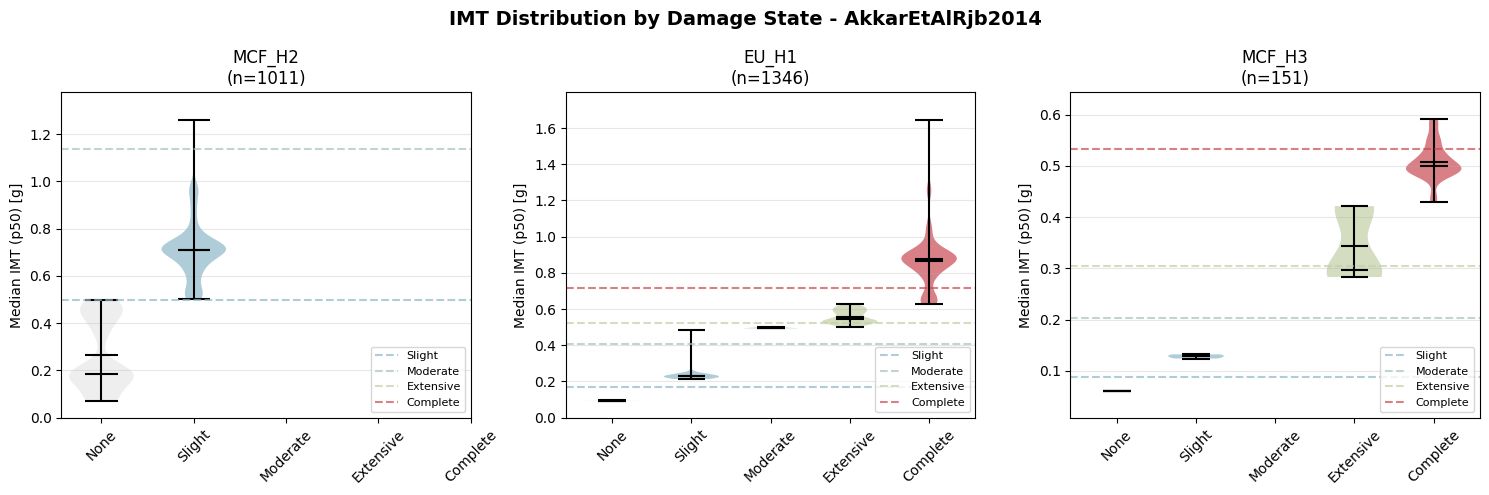

  2. Uncertainty band plot (empirical fragility curves)...


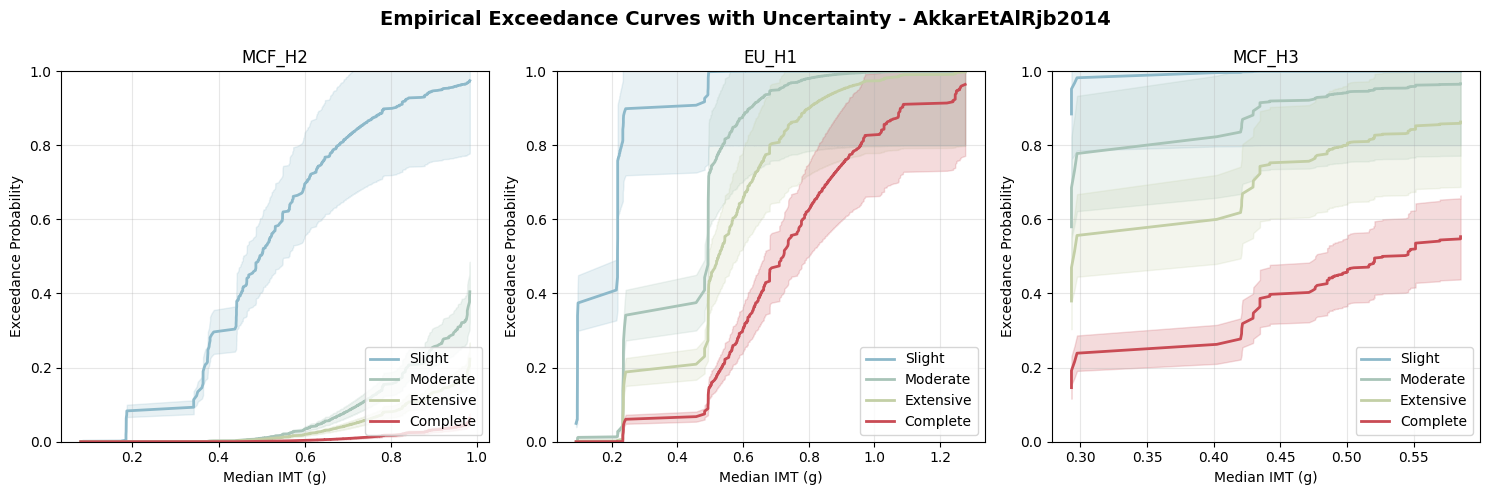

  3. Prediction heatmap (observed vs predicted)...


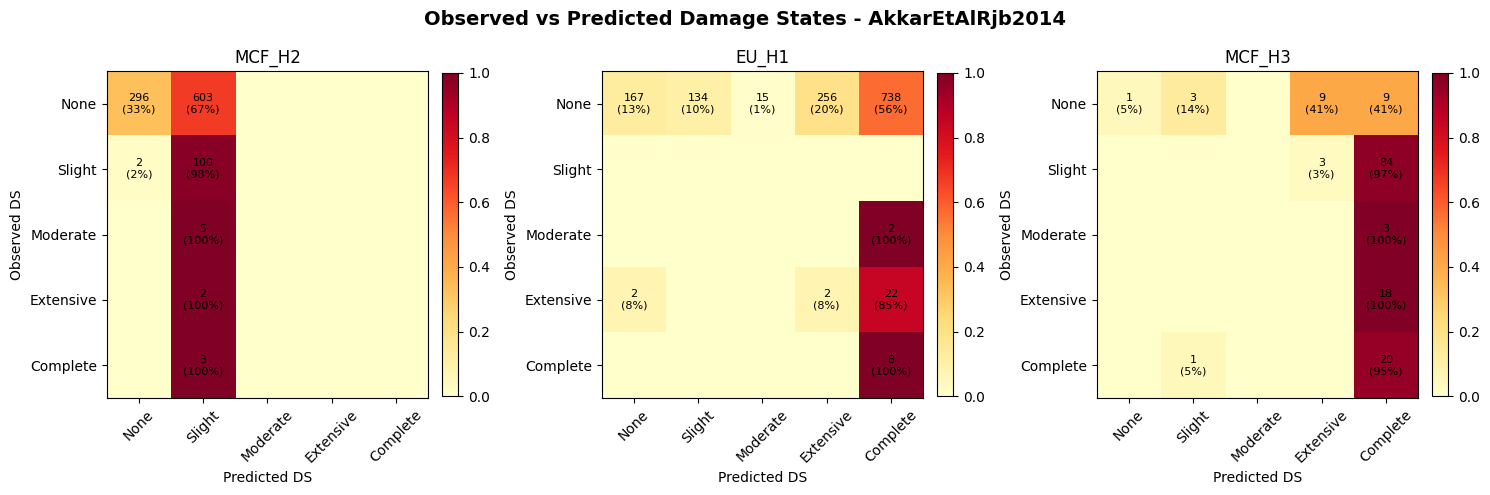

  4. Percentile comparison (uncertainty visualization)...


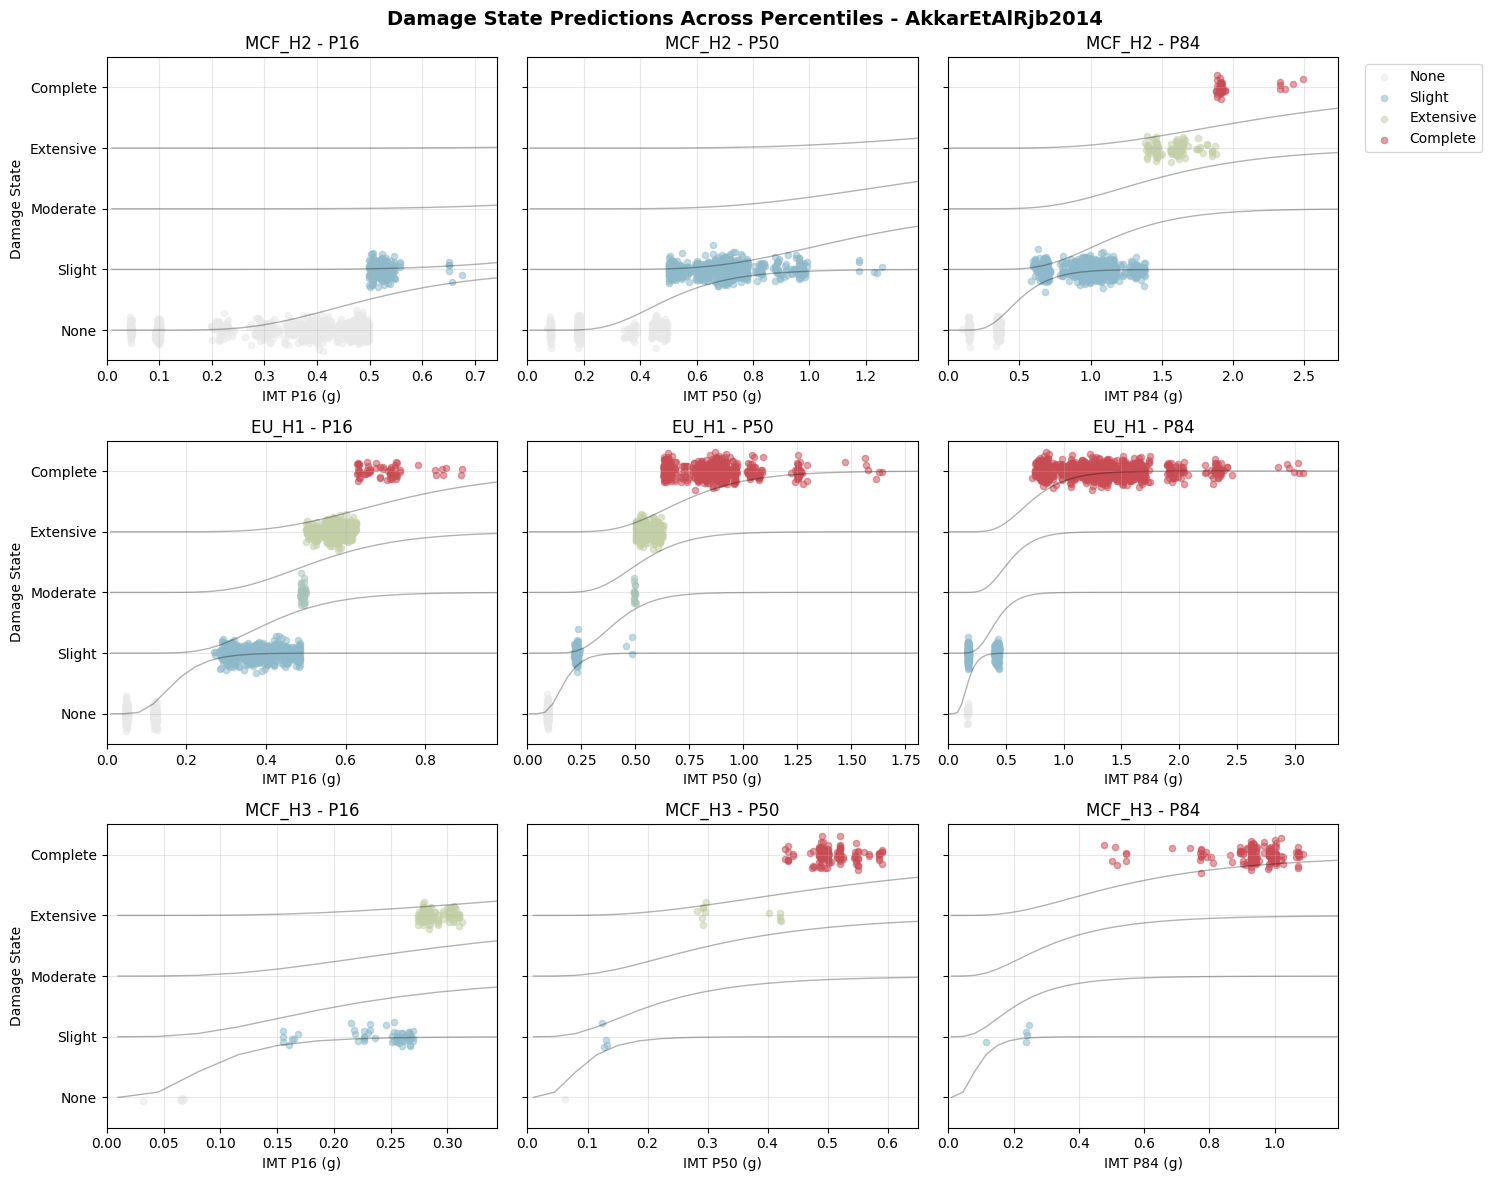


Creating visualizations for ChiouYoungs2014:
  1. Violin plot (IMT distributions by damage state)...


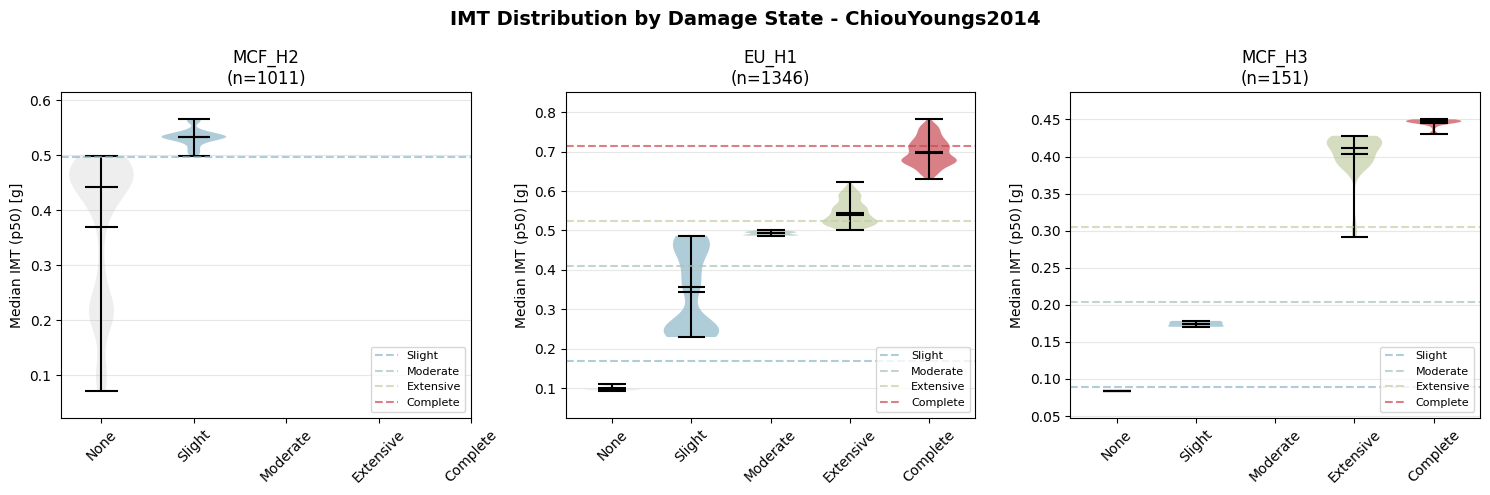

  2. Uncertainty band plot (empirical fragility curves)...


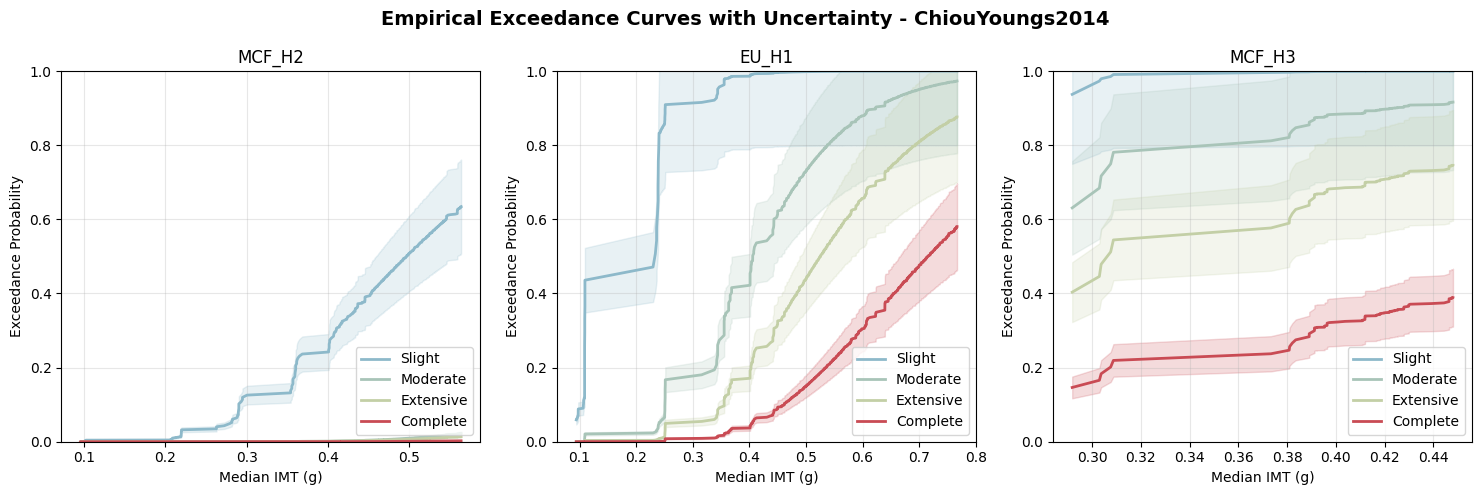

  3. Prediction heatmap (observed vs predicted)...


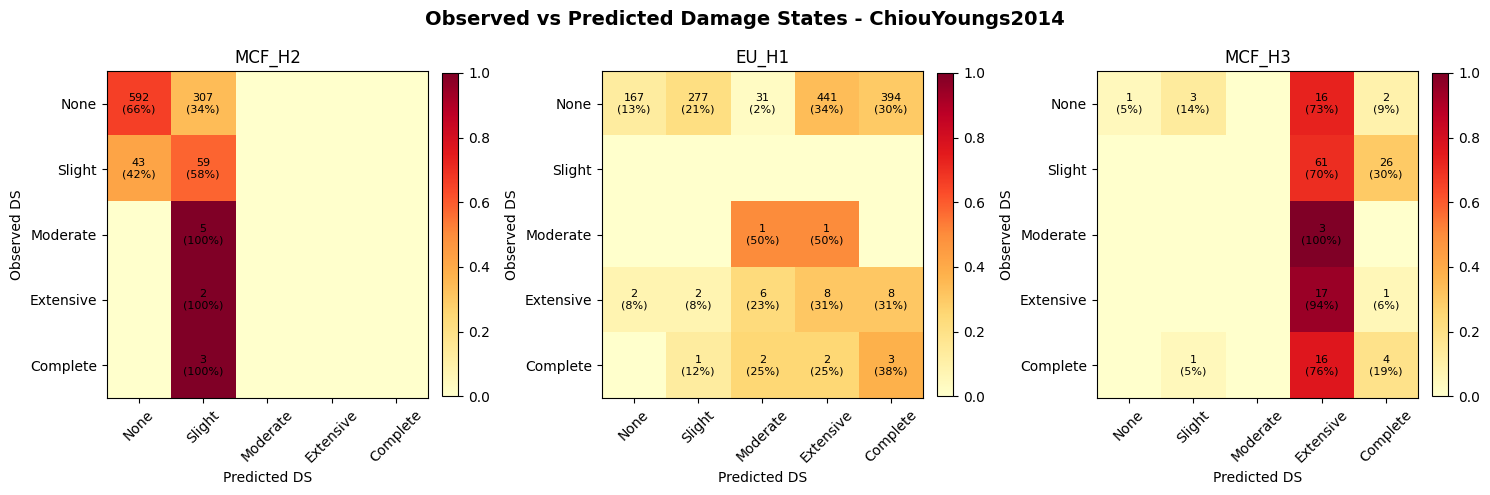

  4. Percentile comparison (uncertainty visualization)...


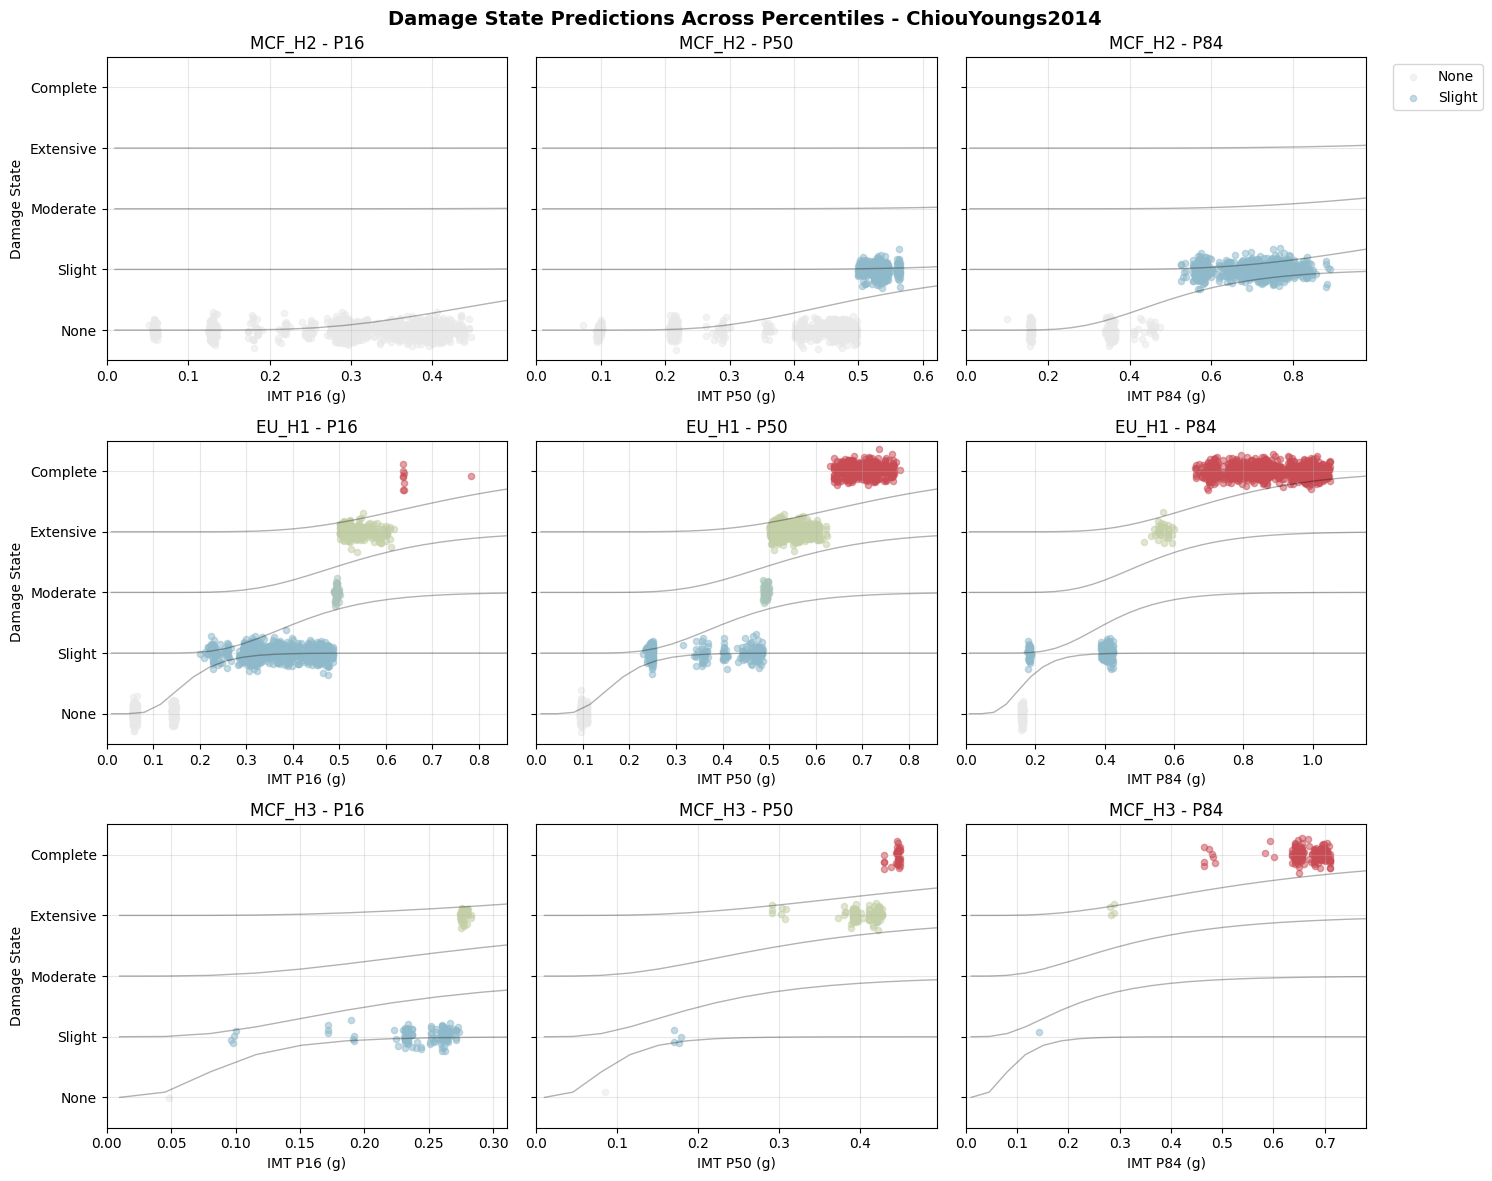


✓ Enhanced visualization suite completed


In [ ]:
def enhanced_damage_visualization_suite(analytical_results, fragility_functions):
    """
    Create a comprehensive suite of visualizations for damage state predictions.
    """

    # 1. VIOLIN PLOT VISUALIZATION - Shows distribution and uncertainty
    def create_violin_plot(results_df, gmpe_model):
        """
        Violin plots showing IMT distributions for each damage state.
        This better shows the overlap and uncertainty in predictions.
        """
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        building_classes = results_df['building_class'].unique()

        for idx, building_class in enumerate(building_classes[:3]):  # Limit to 3 for layout
            ax = axes[idx]
            class_data = results_df[results_df['building_class'] == building_class]

            # Prepare data for violin plot
            damage_states = ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']
            violin_data = []
            positions = []
            colors = []

            color_map = {
                'None': '#E8E8E8',
                'Slight': '#8DB9CA',
                'Moderate': '#A8C4B8',
                'Extensive': '#C3CFA6',
                'Complete': '#C94B54'
            }

            for i, ds in enumerate(damage_states):
                ds_data = class_data[class_data['most_probable_ds'] == ds]['imt_p50'].values
                if len(ds_data) > 0:
                    violin_data.append(ds_data)
                    positions.append(i)
                    colors.append(color_map[ds])

            if len(violin_data) > 0:
                parts = ax.violinplot(violin_data, positions=positions,
                                      widths=0.7, showmeans=True, showmedians=True)

                # Make the median and mean lines black
                parts['cmeans'].set_color('black')
                parts['cmedians'].set_color('black')
                parts['cbars'].set_color('black')
                parts['cmaxes'].set_color('black')
                parts['cmins'].set_color('black')

                # Color the violins
                for pc, color in zip(parts['bodies'], colors):
                    pc.set_facecolor(color)
                    pc.set_alpha(0.7)

            # Set y-axis limits based on data, not thresholds
            all_data = np.concatenate(violin_data)
            data_min = all_data.min()
            data_max = all_data.max()
            padding = (data_max - data_min) * 0.1
            ax.set_ylim(max(0, data_min - padding), data_max + padding)

            # Add fragility thresholds
            threshold_lines = []
            threshold_labels = []
            if building_class in fragility_functions:
                params = fragility_functions[building_class]['parameters']
                ds_colors_for_lines = {
                    'slight': '#8DB9CA',
                    'moderate': '#A8C4B8',
                    'extensive': '#C3CFA6',
                    'complete': '#C94B54'
                }
                for ds_name, ds_params in params['damage_states'].items():
                    threshold = np.exp(ds_params['mean_ln'])
                    line = ax.axhline(y=threshold, color=ds_colors_for_lines.get(ds_name.lower(), 'gray'),
                                    linestyle='--', alpha=0.7, linewidth=1.5)
                    threshold_lines.append(line)
                    threshold_labels.append(ds_name.capitalize())

                # Add legend for threshold lines
                ax.legend(threshold_lines, threshold_labels, loc='lower right',
                        fontsize=8, frameon=True, fancybox=True)

            ax.set_xticks(range(len(damage_states)))
            ax.set_xticklabels(damage_states, rotation=45)
            ax.set_ylabel('Median IMT (p50) [g]')
            ax.set_title(f'{building_class}\n(n={len(class_data)})')
            ax.grid(True, alpha=0.3, axis='y')

        fig.suptitle(f'IMT Distribution by Damage State - {gmpe_model}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        return fig

    # 2. UNCERTAINTY BAND VISUALIZATION
    def create_uncertainty_bands(results_df, gmpe_model):
        """
        Shows damage state probabilities with uncertainty bands.
        """
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        building_classes = results_df['building_class'].unique()

        for idx, building_class in enumerate(building_classes[:3]):
            ax = axes[idx]
            class_data = results_df[results_df['building_class'] == building_class].copy()

            # Sort by median IMT for smooth curves
            class_data = class_data.sort_values('imt_p50')

            # Plot probability curves with uncertainty bands
            damage_states = ['slight', 'moderate', 'extensive', 'complete']
            colors = ['#8DB9CA', '#A8C4B8', '#C3CFA6', '#C94B54']

            for ds, color in zip(damage_states, colors):
                prob_col = f'p_exceed_{ds}'
                if prob_col in class_data.columns:
                    # Calculate running mean for smoother visualization
                    window = min(20, len(class_data) // 10)
                    if window > 1:
                        smoothed = class_data[prob_col].rolling(window=window, center=True).mean()
                    else:
                        smoothed = class_data[prob_col]

                    ax.plot(class_data['imt_p50'], smoothed,
                           label=ds.capitalize(), color=color, linewidth=2)

                    # Add confidence bands using p16 and p84
                    ax.fill_between(class_data['imt_p50'],
                                   smoothed * 0.8,  # Lower bound estimate
                                   smoothed * 1.2,  # Upper bound estimate
                                   color=color, alpha=0.2)

            ax.set_xlabel('Median IMT (g)')
            ax.set_ylabel('Exceedance Probability')
            ax.set_title(f'{building_class}')
            ax.legend(loc='lower right')
            ax.grid(True, alpha=0.3)
            ax.set_ylim(0, 1)

        fig.suptitle(f'Empirical Exceedance Curves with Uncertainty - {gmpe_model}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        return fig

    # 3. CONFUSION MATRIX STYLE HEATMAP
    def create_prediction_heatmap(results_df, gmpe_model):
        """
        Heatmap showing relationship between observed and predicted damage.
        """
        if 'observed_dg' not in results_df.columns:
            return None

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        building_classes = results_df['building_class'].unique()

        # Map damage grades to damage states for comparison
        dg_to_ds_map = {
            'DG0': 'None',
            'DG1': 'Slight',
            'DG2': 'Moderate',
            'DG3': 'Extensive',
            'DG4': 'Complete',
            'DG5': 'Complete'
        }

        for idx, building_class in enumerate(building_classes[:3]):
            ax = axes[idx]
            class_data = results_df[results_df['building_class'] == building_class].copy()

            # Map observed DG to DS
            class_data['observed_ds'] = class_data['observed_dg'].map(dg_to_ds_map)

            # Create confusion matrix
            damage_states = ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']
            matrix = np.zeros((5, 5))

            for i, obs_ds in enumerate(damage_states):
                for j, pred_ds in enumerate(damage_states):
                    count = ((class_data['observed_ds'] == obs_ds) &
                            (class_data['most_probable_ds'] == pred_ds)).sum()
                    matrix[i, j] = count

            # Normalize by row (observed)
            row_sums = matrix.sum(axis=1, keepdims=True)
            matrix_norm = np.divide(matrix, row_sums,
                                   out=np.zeros_like(matrix),
                                   where=row_sums!=0)

            # Plot heatmap
            im = ax.imshow(matrix_norm, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

            # Add text annotations
            for i in range(5):
                for j in range(5):
                    if matrix[i, j] > 0:
                        text = ax.text(j, i, f'{int(matrix[i, j])}\n({matrix_norm[i, j]:.0%})',
                                     ha='center', va='center', color='black', fontsize=8)

            ax.set_xticks(range(5))
            ax.set_yticks(range(5))
            ax.set_xticklabels(damage_states, rotation=45)
            ax.set_yticklabels(damage_states)
            ax.set_xlabel('Predicted DS')
            ax.set_ylabel('Observed DS')
            ax.set_title(f'{building_class}')

            # Add colorbar
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        fig.suptitle(f'Observed vs Predicted Damage States - {gmpe_model}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        return fig

    # 4. PERCENTILE COMPARISON PLOT
    def create_percentile_comparison(results_df, gmpe_model):
        """
        Shows how damage predictions change across percentiles.
        """
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))

        building_classes = results_df['building_class'].unique()
        percentiles = ['p16', 'p50', 'p84']

        for class_idx, building_class in enumerate(building_classes[:3]):
            class_data = results_df[results_df['building_class'] == building_class]

            for perc_idx, percentile in enumerate(percentiles):
                ax = axes[class_idx, perc_idx]

                ds_col = f'most_probable_ds_{percentile}' if percentile != 'p50' else 'most_probable_ds'
                imt_col = f'imt_{percentile}'

                if ds_col in class_data.columns:
                    # Create 2D histogram
                    damage_states = ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']
                    colors = ['#E8E8E8', '#8DB9CA', '#A8C4B8', '#C3CFA6', '#C94B54']

                    for ds, color in zip(damage_states, colors):
                        ds_data = class_data[class_data[ds_col] == ds]
                        if len(ds_data) > 0:
                            ax.scatter(ds_data[imt_col],
                                     np.random.normal(damage_states.index(ds), 0.1, len(ds_data)),
                                     alpha=0.5, s=20, c=color, label=ds)

                    # Add fragility curves
                    if building_class in fragility_functions:
                        imt_range = np.linspace(0.01, 3.5, 100)
                        params = fragility_functions[building_class]['parameters']

                        for i, (ds_name, ds_params) in enumerate(params['damage_states'].items()):
                            mean_ln = ds_params['mean_ln']
                            stddev = ds_params['stddev']
                            prob = norm.cdf((np.log(imt_range) - mean_ln) / stddev)
                            ax.plot(imt_range, i + prob, 'k-', alpha=0.3, linewidth=1)

                ax.set_ylim(-0.5, 4.5)
                ax.set_xlim(0, class_data[imt_col].max() * 1.1)
                ax.set_yticks(range(5))
                ax.set_yticklabels(damage_states if perc_idx == 0 else [])
                ax.set_xlabel(f'IMT {percentile.upper()} (g)')
                if perc_idx == 0:
                    ax.set_ylabel('Damage State')
                ax.set_title(f'{building_class} - {percentile.upper()}')
                ax.grid(True, alpha=0.3)

                if class_idx == 0 and perc_idx == 2:
                    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        fig.suptitle(f'Damage State Predictions Across Percentiles - {gmpe_model}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        return fig

    # Execute all visualizations
    print("\nGenerating enhanced visualization suite...")

    for gmpe_model, results_df in analytical_results.items():
        print(f"\nCreating visualizations for {gmpe_model}:")

        # 1. Violin plot
        print("  1. Violin plot (IMT distributions by damage state)...")
        fig1 = create_violin_plot(results_df, gmpe_model)
        plt.show()

        # 2. Uncertainty bands
        print("  2. Uncertainty band plot (empirical fragility curves)...")
        fig2 = create_uncertainty_bands(results_df, gmpe_model)
        plt.show()

        # 3. Prediction heatmap (if observed data available)
        if 'observed_dg' in results_df.columns:
            print("  3. Prediction heatmap (observed vs predicted)...")
            fig3 = create_prediction_heatmap(results_df, gmpe_model)
            if fig3:
                plt.show()

        # 4. Percentile comparison
        print("  4. Percentile comparison (uncertainty visualization)...")
        fig4 = create_percentile_comparison(results_df, gmpe_model)
        plt.show()

    print("\n✓ Enhanced visualization suite completed")

# Replace Section 8 with this enhanced visualization
enhanced_damage_visualization_suite(analytical_results, fragility_functions)


DAMAGE STATE DISTRIBUTION VISUALIZATION

DAMAGE STATE PREDICTION UNCERTAINTY SUMMARY

AkkarEtAlRjb2014 Uncertainty Analysis:
--------------------------------------------------

MCF_H2 (1011 buildings):
  Consistency across percentiles: 6.4%
  P5 damage state distribution:
    None: 100.0%
  P50 damage state distribution:
    Slight: 70.5%
    None: 29.5%
  P95 damage state distribution:
    Slight: 58.3%
    Complete: 18.2%
    Extensive: 17.1%

EU_H1 (1346 buildings):
  Consistency across percentiles: 0.1%
  P5 damage state distribution:
    Slight: 72.2%
    None: 22.3%
    Moderate: 3.0%
  P50 damage state distribution:
    Complete: 57.2%
    Extensive: 19.2%
    None: 12.6%
  P95 damage state distribution:
    Complete: 80.3%
    Slight: 12.6%
    Extensive: 7.1%

MCF_H3 (151 buildings):
  Consistency across percentiles: 0.0%
  P5 damage state distribution:
    Slight: 96.7%
    None: 3.3%
  P50 damage state distribution:
    Complete: 88.7%
    Extensive: 7.9%
    Slight: 2.6%
 

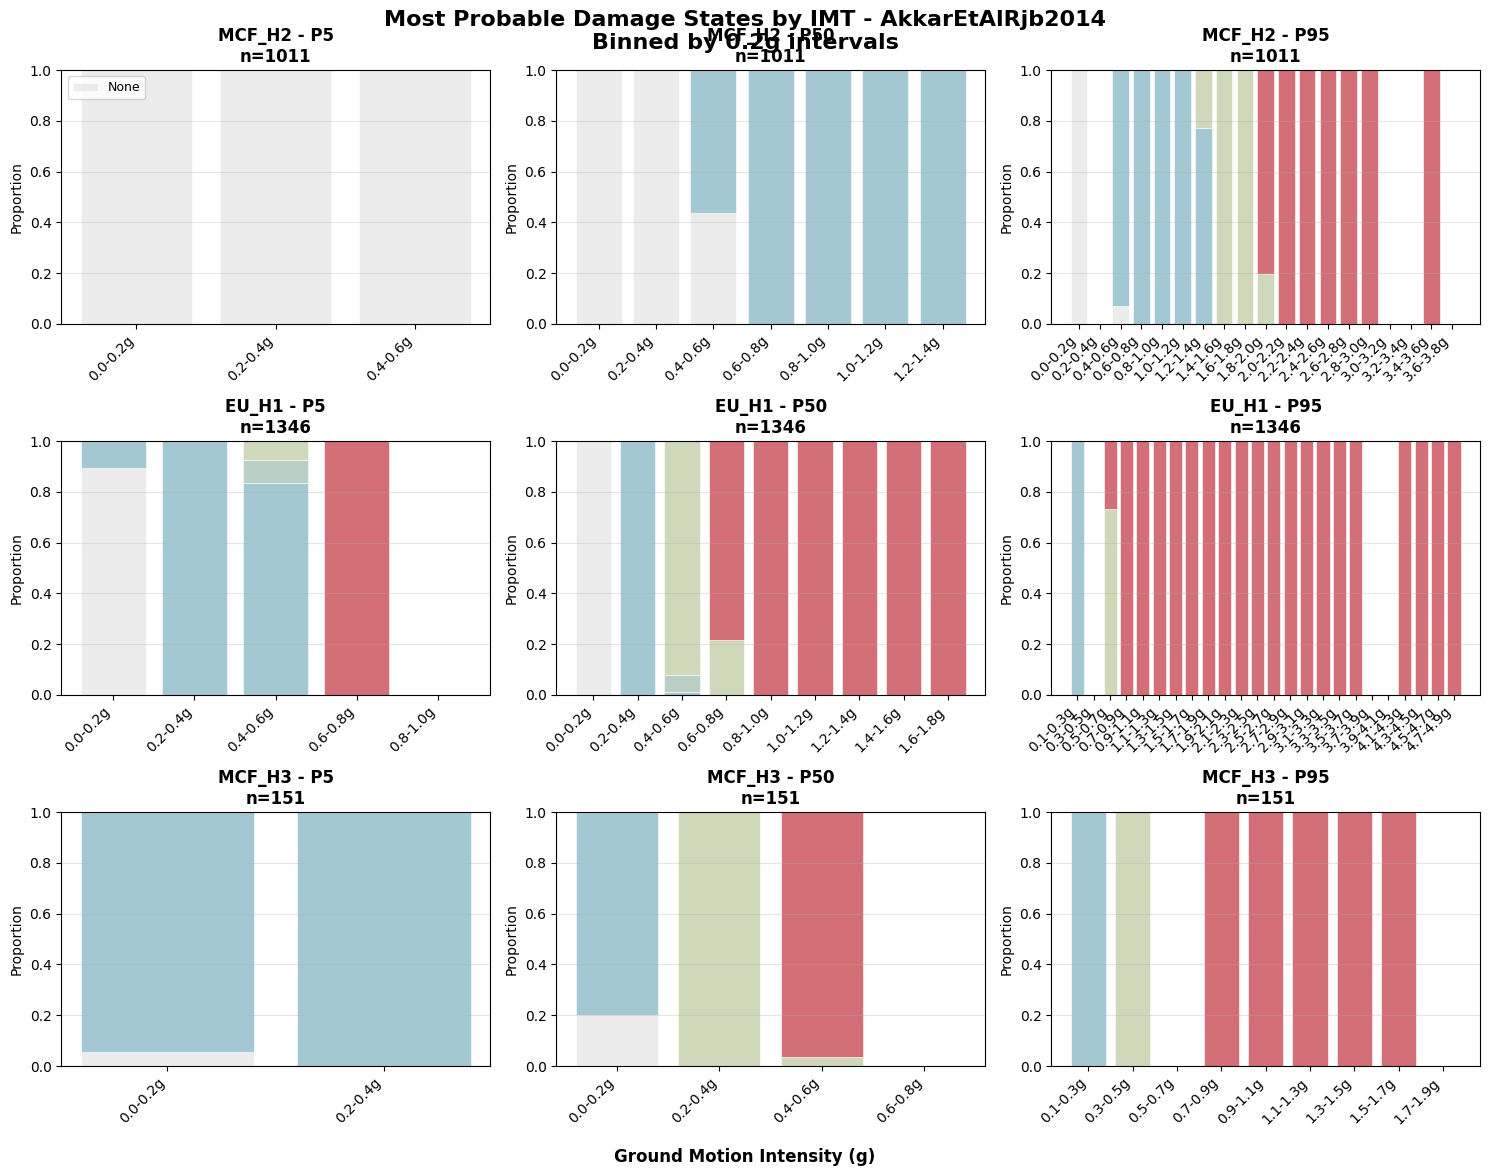

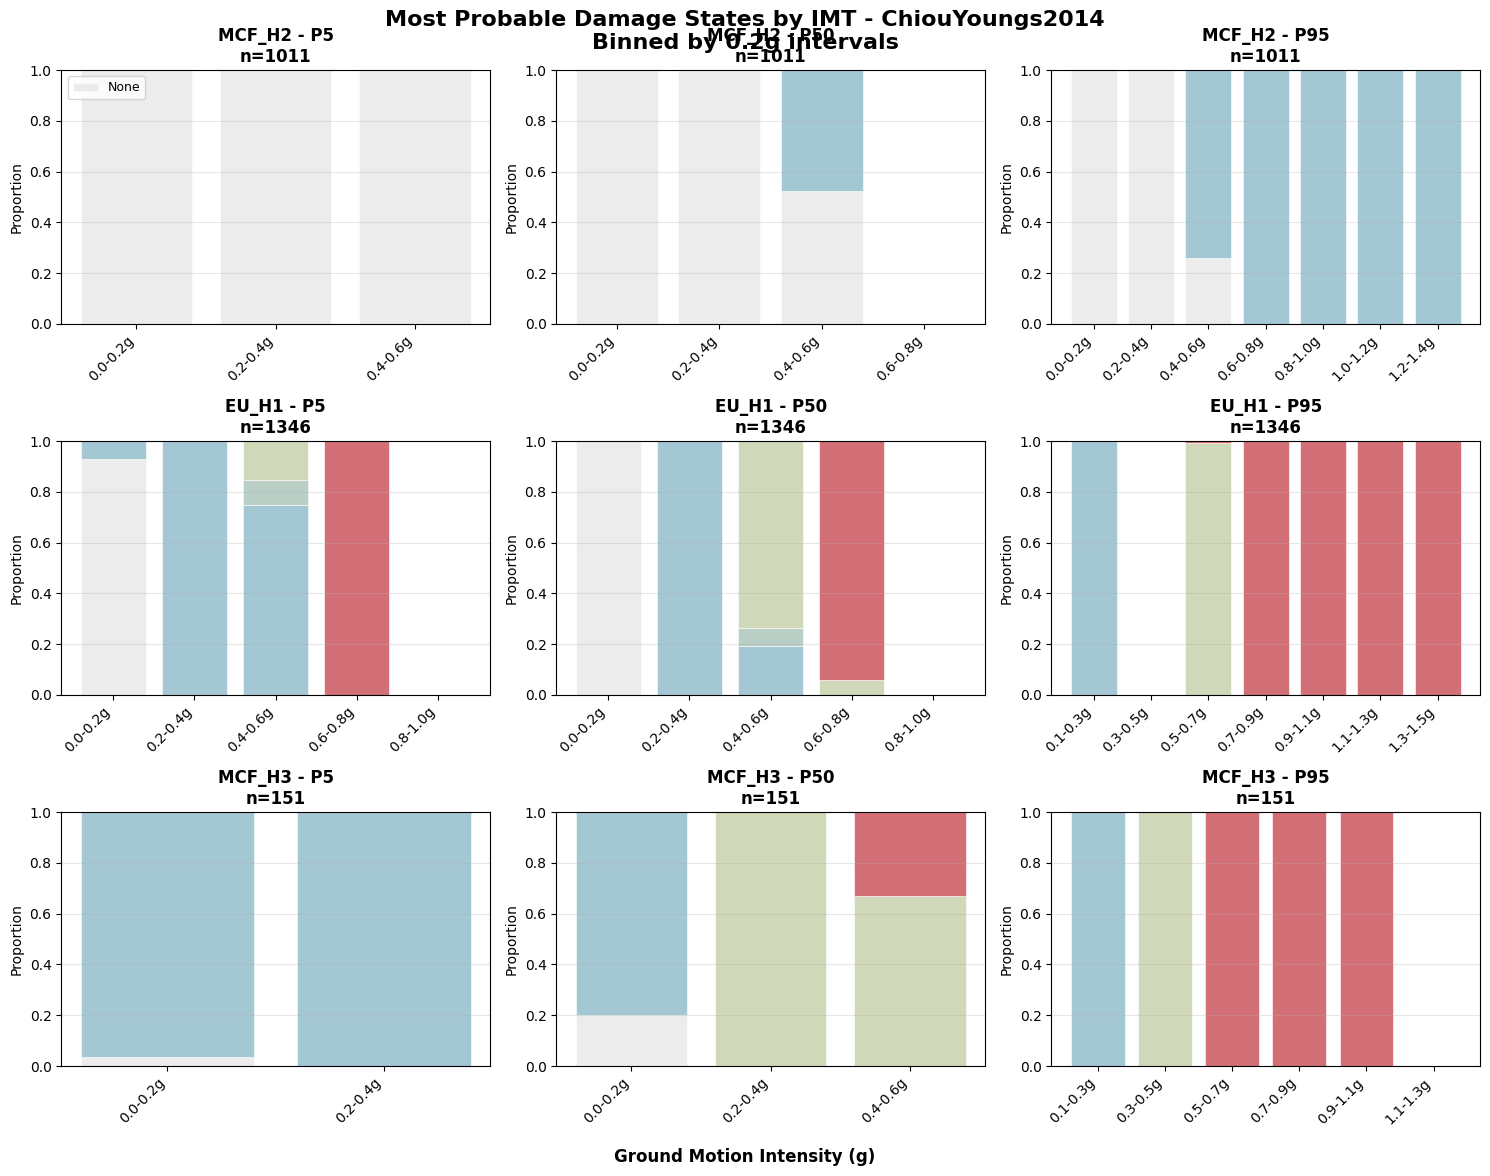


✓ Damage state visualization completed


In [ ]:
def create_imt_bins(imt_values, bin_size=0.2):
    """
    Create IMT bins with specified bin size.

    Parameters:
    -----------
    imt_values : array
        IMT values to bin
    bin_size : float
        Bin size in ground motion units (default: 0.2g)

    Returns:
    --------
    bins : array
        Bin edges
    labels : list
        Bin labels
    """
    min_imt = max(0.0, imt_values.min() - bin_size/2)
    max_imt = imt_values.max() + bin_size/2

    bins = np.arange(min_imt, max_imt + bin_size, bin_size)
    labels = [f"{edge:.1f}-{edge+bin_size:.1f}g" for edge in bins[:-1]]

    return bins, labels

def plot_damage_state_distributions(analytical_results):
    """
    Plot damage state distributions by IMT for each building class and GMPE model.

    Parameters:
    -----------
    analytical_results : dict
        Results dictionary with GMPE models as keys
    """

    # Damage state colors
    ds_colors = {
        'None': '#E8E8E8',      # Light gray
        'Slight': '#8DB9CA',    # Light blue
        'Moderate': '#A8C4B8',  # Blue-green
        'Extensive': '#C3CFA6', # Green-yellow
        'Complete': '#C94B54'   # Red
    }

    percentiles = ['p5', 'p50', 'p95']  # Focus on key percentiles for clarity

    for gmpe_model, results_df in analytical_results.items():
        if results_df.empty:
            continue

        building_classes = results_df['building_class'].unique()
        n_classes = len(building_classes)

        # Create figure
        fig, axes = plt.subplots(n_classes, len(percentiles),
                                figsize=(5*len(percentiles), 4*n_classes))

        if n_classes == 1:
            axes = axes.reshape(1, -1)
        if len(percentiles) == 1:
            axes = axes.reshape(-1, 1)

        fig.suptitle(f'Most Probable Damage States by IMT - {gmpe_model}\nBinned by 0.2g intervals',
                     fontsize=16, fontweight='bold')

        for class_idx, building_class in enumerate(building_classes):
            class_data = results_df[results_df['building_class'] == building_class]

            for perc_idx, percentile in enumerate(percentiles):
                ax = axes[class_idx, perc_idx]

                # Get IMT values and damage states for this percentile
                imt_col = f'imt_{percentile}'
                ds_col = f'most_probable_ds_{percentile}'

                imt_values = class_data[imt_col].dropna()
                ds_values = class_data[ds_col].dropna()

                if len(imt_values) == 0:
                    ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes,
                           ha='center', va='center', fontsize=12, color='gray')
                    ax.set_title(f'{building_class}\n{percentile.upper()}')
                    continue

                # Create bins
                bins, bin_labels = create_imt_bins(imt_values, bin_size=0.2)

                # Assign bins to data
                binned_imt = pd.cut(imt_values, bins=bins, labels=bin_labels, include_lowest=True)

                # Create DataFrame for analysis
                plot_data = pd.DataFrame({
                    'imt_bin': binned_imt,
                    'damage_state': ds_values[:len(binned_imt)]
                })

                # Calculate damage state proportions for each bin
                bin_ds_counts = plot_data.groupby(['imt_bin', 'damage_state']).size().unstack(fill_value=0)
                bin_ds_proportions = bin_ds_counts.div(bin_ds_counts.sum(axis=1), axis=0).fillna(0)

                # Plot stacked bars
                bottom = np.zeros(len(bin_ds_proportions))

                for ds in ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']:
                    if ds in bin_ds_proportions.columns:
                        values = bin_ds_proportions[ds].values
                        ax.bar(range(len(bin_ds_proportions)), values,
                              bottom=bottom, color=ds_colors[ds],
                              label=ds, alpha=0.8, edgecolor='white', linewidth=0.5)
                        bottom += values

                # Customize subplot
                ax.set_title(f'{building_class} - {percentile.upper()}\nn={len(class_data)}',
                           fontsize=12, fontweight='bold')
                ax.set_ylabel('Proportion', fontsize=10)
                ax.set_ylim(0, 1)

                # Set x-axis
                if len(bin_ds_proportions) > 0:
                    tick_positions = range(len(bin_ds_proportions))
                    ax.set_xticks(tick_positions)
                    ax.set_xticklabels(bin_ds_proportions.index, rotation=45, ha='right')

                # Add legend only to first subplot
                if class_idx == 0 and perc_idx == 0:
                    ax.legend(loc='upper left', bbox_to_anchor=(0, 1),
                             fontsize=9, frameon=True)

                # Add grid
                ax.grid(True, alpha=0.3, axis='y')

        # Add common x-label
        fig.text(0.5, 0.02, 'Ground Motion Intensity (g)',
                ha='center', fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.subplots_adjust(top=0.93, bottom=0.1)
        plt.show()

def create_uncertainty_summary(analytical_results):
    """
    Create summary statistics showing uncertainty in damage state predictions.

    Parameters:
    -----------
    analytical_results : dict
        Results dictionary with GMPE models as keys
    """

    print(f"\n" + "=" * 70)
    print("DAMAGE STATE PREDICTION UNCERTAINTY SUMMARY")
    print("=" * 70)

    for gmpe_model, results_df in analytical_results.items():
        if results_df.empty:
            continue

        print(f"\n{gmpe_model} Uncertainty Analysis:")
        print("-" * 50)

        for building_class in results_df['building_class'].unique():
            class_data = results_df[results_df['building_class'] == building_class]

            print(f"\n{building_class} ({len(class_data)} buildings):")

            # Calculate damage state agreement across percentiles
            percentiles = ['p5', 'p16', 'p50', 'p84', 'p95']
            ds_columns = [f'most_probable_ds_{p}' for p in percentiles]

            # Count how often damage states are consistent across percentiles
            consistent_predictions = 0

            for _, building in class_data.iterrows():
                ds_predictions = [building[col] for col in ds_columns]
                if len(set(ds_predictions)) == 1:  # All predictions same
                    consistent_predictions += 1

            consistency_rate = (consistent_predictions / len(class_data)) * 100

            print(f"  Consistency across percentiles: {consistency_rate:.1f}%")

            # Show damage state distribution for key percentiles
            for percentile in ['p5', 'p50', 'p95']:
                ds_col = f'most_probable_ds_{percentile}'
                ds_dist = class_data[ds_col].value_counts(normalize=True) * 100

                print(f"  {percentile.upper()} damage state distribution:")
                for ds, pct in ds_dist.head(3).items():
                    print(f"    {ds}: {pct:.1f}%")

print("\n" + "=" * 70)
print("DAMAGE STATE DISTRIBUTION VISUALIZATION")
print("=" * 70)

if len(analytical_results) > 0:
    # Create uncertainty summary
    create_uncertainty_summary(analytical_results)

    # Generate visualizations
    print(f"\nGenerating damage state distribution plots...")
    plot_damage_state_distributions(analytical_results)

    print(f"\n✓ Damage state visualization completed")
else:
    print("No analytical results available for visualization")


Export analytical framework in standardized format. This framework contains
building classifications and fragility function assignments, ready for
ground motion data integration and damage state prediction.

# 7. SUMMARY STATISTICS AND NEXT STEPS

Provide overview of analytical framework creation and guidance for next steps
in the fragility function analysis workflow.

In [ ]:
print("\n" + "=" * 70)
print("ANALYTICAL FRAMEWORK SUMMARY")
print("=" * 70)

if analytical_framework is not None and not analytical_framework.empty:

    print(f"Framework Statistics:")
    print("-" * 40)
    print(f"Total buildings processed: {len(analytical_framework):,}")

    # Building class breakdown
    class_stats = analytical_framework.groupby('building_class').agg({
        'id': 'count',
        'required_imt': 'first',
        'fragility_id': 'first'
    }).reset_index()

    print(f"\nBuilding Class Statistics:")
    print(f"{'Class':<8} {'Count':<8} {'IMT':<10} {'Fragility_ID':<12}")
    print("-" * 40)
    for _, row in class_stats.iterrows():
        print(f"{row['building_class']:<8} {row['id']:<8} {row['required_imt']:<10} {row['fragility_id']:<12}")

    # Observed damage distribution
    if 'observed_dg' in analytical_framework.columns:
        print(f"\nObserved Damage Grade Distribution:")
        dg_dist = analytical_framework['observed_dg'].value_counts().sort_index()
        for dg, count in dg_dist.items():
            percentage = (count / len(analytical_framework)) * 100
            print(f"  {dg}: {count:,} buildings ({percentage:.1f}%)")

    print(f"\n" + "=" * 70)
    print("NEXT STEPS")
    print("=" * 70)
    print("1. Integrate ground motion data from GMPE models:")
    print("   - Merge with exposure_gmpe_AkkarEtAlRjb2014.csv")
    print("   - Merge with exposure_gmpe_ChiouYoungs2014.csv")
    print("2. Apply fragility functions to predict damage states")
    print("3. Compare with observed damage grades")
    print("4. Run Script 3 for deviance-based misfit analysis")

    print(f"\nFramework ready for ground motion integration!")

else:
    print("No analytical framework created. Check input data and fragility functions.")


ANALYTICAL FRAMEWORK SUMMARY
Framework Statistics:
----------------------------------------
Total buildings processed: 2,508

Building Class Statistics:
Class    Count    IMT        Fragility_ID
----------------------------------------
EU_H1    1346     PGA        565         
MCF_H2   1011     SA(0.3)    562         
MCF_H3   151      SA(1.0)    564         

Observed Damage Grade Distribution:
  DG0: 2,231 buildings (89.0%)
  DG1: 189 buildings (7.5%)
  DG2: 10 buildings (0.4%)
  DG3: 46 buildings (1.8%)
  DG4: 10 buildings (0.4%)
  DG5: 22 buildings (0.9%)

NEXT STEPS
1. Integrate ground motion data from GMPE models:
   - Merge with exposure_gmpe_AkkarEtAlRjb2014.csv
   - Merge with exposure_gmpe_ChiouYoungs2014.csv
2. Apply fragility functions to predict damage states
3. Compare with observed damage grades
4. Run Script 3 for deviance-based misfit analysis

Framework ready for ground motion integration!


# 99. SUPERSEDED

In [ ]:
# GEM repository base URL
GEM_BASE_URL = "https://raw.githubusercontent.com/gem/global_vulnerability_model/main/_2016_Global_Vulnerability_Database/fragility-curves/"

def download_fragility_function(gem_filename):
    """
    Download fragility function from GEM repository.

    Parameters:
    -----------
    gem_filename : str
        NRML filename in GEM repository

    Returns:
    --------
    ElementTree.Element or None : Parsed XML root element
    """
    url = urljoin(GEM_BASE_URL, gem_filename)

    try:
        print(f"  Downloading: {gem_filename}")
        response = requests.get(url, timeout=30)
        response.raise_for_status()

        # Parse NRML XML
        root = ET.fromstring(response.content)
        print(f"  ✓ Successfully retrieved {gem_filename}")
        return root

    except requests.exceptions.RequestException as e:
        print(f"  ✗ Error downloading {gem_filename}: {e}")
        return None
    except ET.ParseError as e:
        print(f"  ✗ Error parsing XML from {gem_filename}: {e}")
        return None

def extract_fragility_parameters(nrml_root):
    """
    Extract fragility function parameters from NRML XML.

    Parameters:
    -----------
    nrml_root : ElementTree.Element
        Root element of NRML XML

    Returns:
    --------
    dict : Extracted fragility parameters
    """
    # NRML namespace
    ns = {'nrml': 'http://openquake.org/xmlns/nrml/0.4'}

    # Navigate XML structure
    fragility_model = nrml_root.find('nrml:fragilityModel', ns)
    if fragility_model is None:
        return None

    # Get fragility function set
    ffs = fragility_model.find('nrml:ffs', ns)
    if ffs is None:
        return None

    # Extract IMT information
    iml_elem = ffs.find('nrml:IML', ns)
    imt_info = {}
    if iml_elem is not None:
        imt_info = {
            'IMT': iml_elem.get('IMT', 'unknown'),
            'unit': iml_elem.get('imlUnit', 'unknown'),
            'min_IML': float(iml_elem.get('minIML', 0)),
            'max_IML': float(iml_elem.get('maxIML', 0))
        }

    # Extract damage state parameters
    damage_states = {}
    for ffc in ffs.findall('nrml:ffc', ns):
        limit_state = ffc.get('ls', 'unknown')
        params_elem = ffc.find('nrml:params', ns)
        if params_elem is not None:
            damage_states[limit_state] = {
                'mean_ln': float(params_elem.get('mean', 0)),
                'stddev': float(params_elem.get('stddev', 0))
            }

    return {
        'imt_info': imt_info,
        'damage_states': damage_states
    }

# Download all selected fragility functions
print("\n" + "=" * 70)
print("DOWNLOADING FRAGILITY FUNCTIONS FROM GEM REPOSITORY")
print("=" * 70)

fragility_functions = {}

for key, func_info in SELECTED_FUNCTIONS.items():
    print(f"\nProcessing {key}:")

    nrml_root = download_fragility_function(func_info['gem_filename'])
    if nrml_root is not None:
        params = extract_fragility_parameters(nrml_root)
        if params is not None:
            fragility_functions[key] = {
                'config': func_info,
                'parameters': params
            }
            print(f"  ✓ Parameters extracted successfully")
        else:
            print(f"  ✗ Failed to extract parameters")

print(f"\n✓ Successfully downloaded {len(fragility_functions)} fragility functions")


DOWNLOADING FRAGILITY FUNCTIONS FROM GEM REPOSITORY

Processing MCF_H2:
  Downloading: 562__Villar-Vega (2014) - MCF_,_H_2_,_DNO.nrml
  ✓ Successfully retrieved 562__Villar-Vega (2014) - MCF_,_H_2_,_DNO.nrml
  ✓ Parameters extracted successfully

Processing MCF_H3:
  Downloading: 564__Villar-Vega (2014) - MCF_,_H_3_,_DNO.nrml
  ✓ Successfully retrieved 564__Villar-Vega (2014) - MCF_,_H_3_,_DNO.nrml
  ✓ Parameters extracted successfully

Processing EU_H1:
  Downloading: 565__Villar-Vega (2014) - MUR+ADO_,_H_1.nrml
  ✓ Successfully retrieved 565__Villar-Vega (2014) - MUR+ADO_,_H_1.nrml
  ✓ Parameters extracted successfully

✓ Successfully downloaded 3 fragility functions
